In [1]:
import os

In [2]:
%pwd

'D:\\Desktop\\Superteams AI\\Task 2 Vector Databases can help with Anomaly Detection\\Vector-Databases-can-help-with-Anomaly-Detection\\Research - Qdrant'

In [3]:
os.chdir("../")

In [4]:
%pwd

'D:\\Desktop\\Superteams AI\\Task 2 Vector Databases can help with Anomaly Detection\\Vector-Databases-can-help-with-Anomaly-Detection'

In [5]:
import logging
from pathlib import Path
logging.basicConfig(
    # filename='extract_data.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [6]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("Dataset/financial_news.csv")
df.head()

,title,summary,link,published
0,"Kotak Mahindra Bank's loan, deposit growth may...","Kotak Mahindra Bank's loan, deposit growth may...",https://realtime.rediff.com/news/business/Kota...,1 hour(s) ago
1,Above-normal monsoon likely to ease food price...,Above-normal monsoon likely to ease food price...,https://realtime.rediff.com/news/business/Abov...,3 hour(s) ago
2,Deloitte pegs India's FY25 GDP growth at 6.6%,Deloitte pegs India's FY25 GDP growth at 6.6%\...,https://realtime.rediff.com/news/business/Delo...,4 hour(s) ago
3,Good times ahead for United Breweries as heatw...,Good times ahead for United Breweries as heatw...,https://realtime.rediff.com/news/business/Good...,4 hour(s) ago
4,Tech Mahindra jumps over 12% in opening trade,Tech Mahindra jumps over 12% in opening trade\...,https://realtime.rediff.com/news/business/Tech...,5 hour(s) ago


In [7]:
logging.info("Loaded financial news dataset")

2024-04-26 16:21:41 - INFO - Loaded financial news dataset


# Loading embeddding Model

In [8]:
from sentence_transformers import SentenceTransformer

D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# from transformers import AutoTokenizer, AutoModel
# from pathlib import Path

# def download_model_and_tokenizer(model_name, save_path):
#     """
#     Download and save both the model and the tokenizer to the specified directory.

#     Parameters:
#         model_name (str): Name of the model to download.
#         save_path (str or Path): Path to the directory where the model and tokenizer will be saved.
#     """
#     # Create the save path if it doesn't exist
#     save_path = Path(save_path)
#     save_path.mkdir(parents=True, exist_ok=True)
    
#     # Initialize tokenizer and model
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)
    
#     # Save tokenizer
#     tokenizer.save_pretrained(save_path)
    
#     # Save model
#     model.save_pretrained(save_path)

# # Example usage
# model_name = 'sentence-transformers/all-MiniLM-L12-v2'  # Model name to download
# save_path = Path("MiniLM-L12-v2/")  # Path where model and tokenizer will be saved
# download_model_and_tokenizer(model_name, save_path)


In [10]:
from transformers import AutoTokenizer, AutoModel

def load_model_and_tokenizer(model_path):
    """
    Load the model and tokenizer from the specified directory.

    Parameters:
        model_path (str or Path): Path to the directory containing the saved model and tokenizer.

    Returns:
        tokenizer (transformers.PreTrainedTokenizer): Loaded tokenizer.
        model (transformers.PreTrainedModel): Loaded model.
    """
    model_path = Path(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    return tokenizer, model

# Load the model and tokenizer
model_path = Path("MiniLM-L12-v2/")
tokenizer, model = load_model_and_tokenizer(model_path)

In [11]:
logging.info("Initialized SentenceTransformer model")

2024-04-26 16:21:48 - INFO - Initialized SentenceTransformer model


In [12]:
df['news'] = df.apply(lambda row: row['title'] + ' ' + row['summary'], axis=1)
df.head()

,title,summary,link,published,news
0,"Kotak Mahindra Bank's loan, deposit growth may...","Kotak Mahindra Bank's loan, deposit growth may...",https://realtime.rediff.com/news/business/Kota...,1 hour(s) ago,"Kotak Mahindra Bank's loan, deposit growth may..."
1,Above-normal monsoon likely to ease food price...,Above-normal monsoon likely to ease food price...,https://realtime.rediff.com/news/business/Abov...,3 hour(s) ago,Above-normal monsoon likely to ease food price...
2,Deloitte pegs India's FY25 GDP growth at 6.6%,Deloitte pegs India's FY25 GDP growth at 6.6%\...,https://realtime.rediff.com/news/business/Delo...,4 hour(s) ago,Deloitte pegs India's FY25 GDP growth at 6.6% ...
3,Good times ahead for United Breweries as heatw...,Good times ahead for United Breweries as heatw...,https://realtime.rediff.com/news/business/Good...,4 hour(s) ago,Good times ahead for United Breweries as heatw...
4,Tech Mahindra jumps over 12% in opening trade,Tech Mahindra jumps over 12% in opening trade\...,https://realtime.rediff.com/news/business/Tech...,5 hour(s) ago,Tech Mahindra jumps over 12% in opening trade ...


# embedding the data 

In [13]:
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def generate_embedding(text):
    # Tokenize input text
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings with model
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Perform mean pooling
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    # Convert to numpy for FAISS compatibility and ensure it's 2D
    return sentence_embedding.cpu().numpy().reshape(1, -1)

In [14]:
# Generate embeddings for the 'input' column
df['encoded_news'] = df['news'].apply(lambda x: generate_embedding(x)[0].tolist())
df.head()

,title,summary,link,published,news,encoded_news
0,"Kotak Mahindra Bank's loan, deposit growth may...","Kotak Mahindra Bank's loan, deposit growth may...",https://realtime.rediff.com/news/business/Kota...,1 hour(s) ago,"Kotak Mahindra Bank's loan, deposit growth may...","[0.106527179479599, 0.01504743006080389, -0.11..."
1,Above-normal monsoon likely to ease food price...,Above-normal monsoon likely to ease food price...,https://realtime.rediff.com/news/business/Abov...,3 hour(s) ago,Above-normal monsoon likely to ease food price...,"[0.07254455238580704, -0.22979262471199036, 0...."
2,Deloitte pegs India's FY25 GDP growth at 6.6%,Deloitte pegs India's FY25 GDP growth at 6.6%\...,https://realtime.rediff.com/news/business/Delo...,4 hour(s) ago,Deloitte pegs India's FY25 GDP growth at 6.6% ...,"[0.06313078850507736, -0.06512495875358582, -0..."
3,Good times ahead for United Breweries as heatw...,Good times ahead for United Breweries as heatw...,https://realtime.rediff.com/news/business/Good...,4 hour(s) ago,Good times ahead for United Breweries as heatw...,"[0.048574283719062805, -0.01917494647204876, -..."
4,Tech Mahindra jumps over 12% in opening trade,Tech Mahindra jumps over 12% in opening trade\...,https://realtime.rediff.com/news/business/Tech...,5 hour(s) ago,Tech Mahindra jumps over 12% in opening trade ...,"[0.05018649622797966, -0.060404229909181595, -..."


# Initialize Qdrant

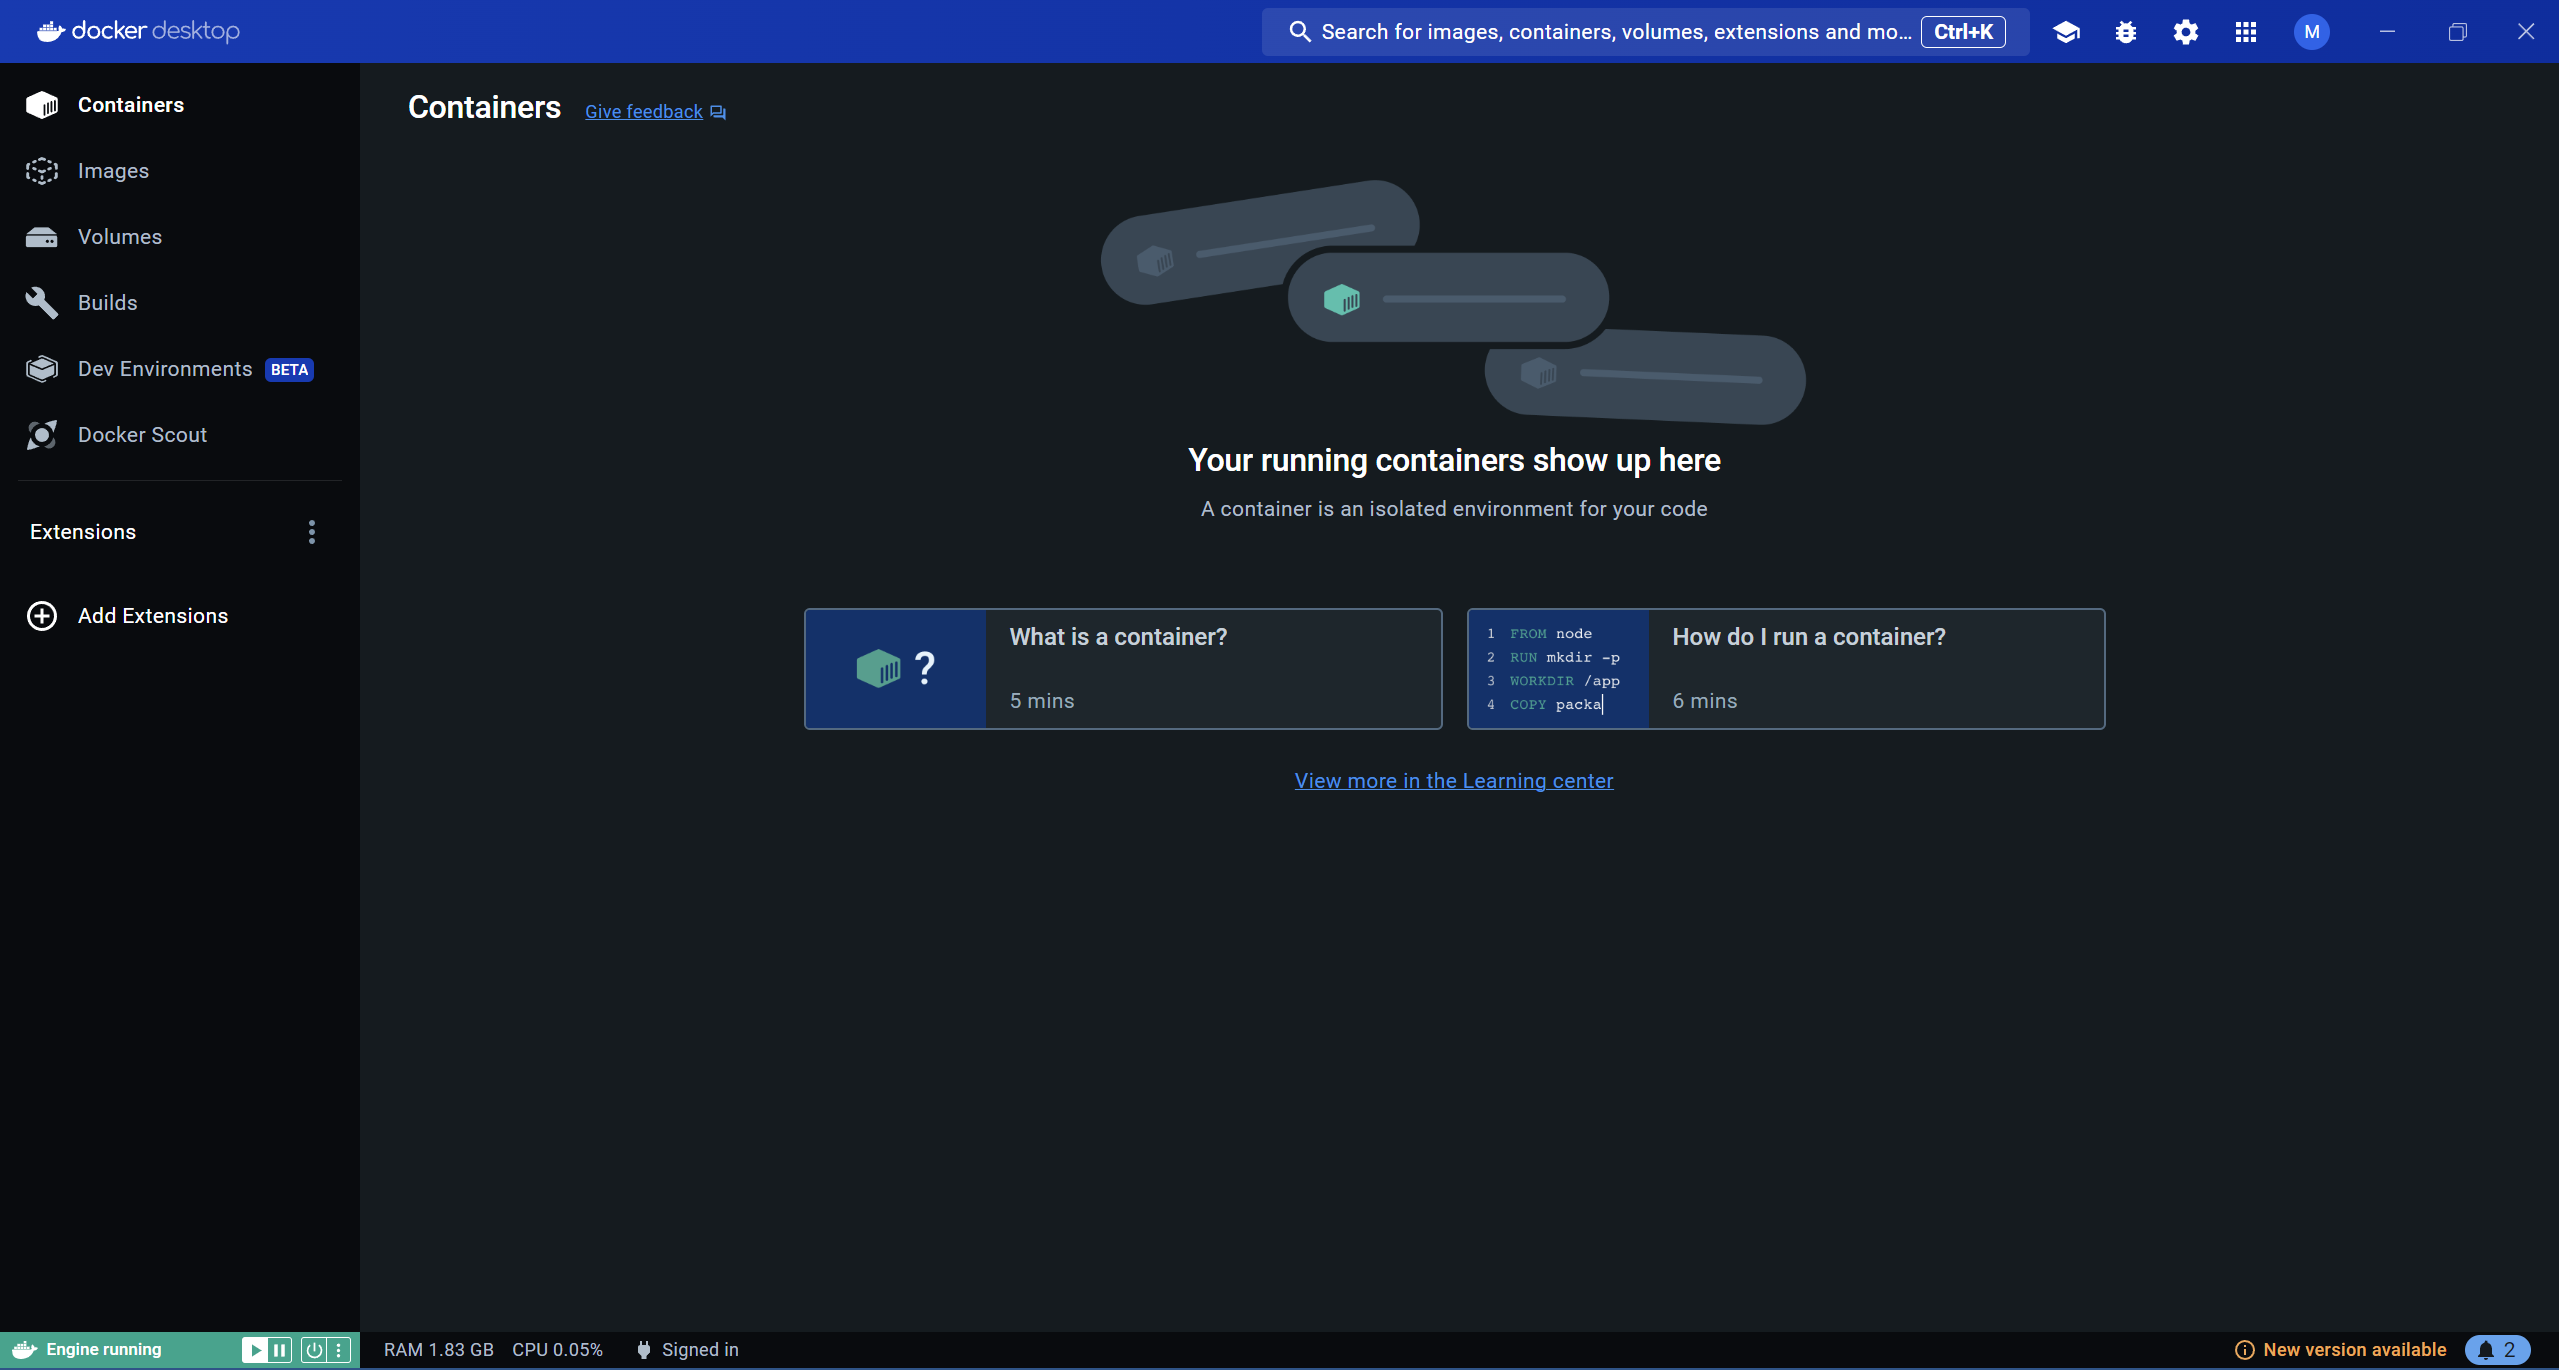

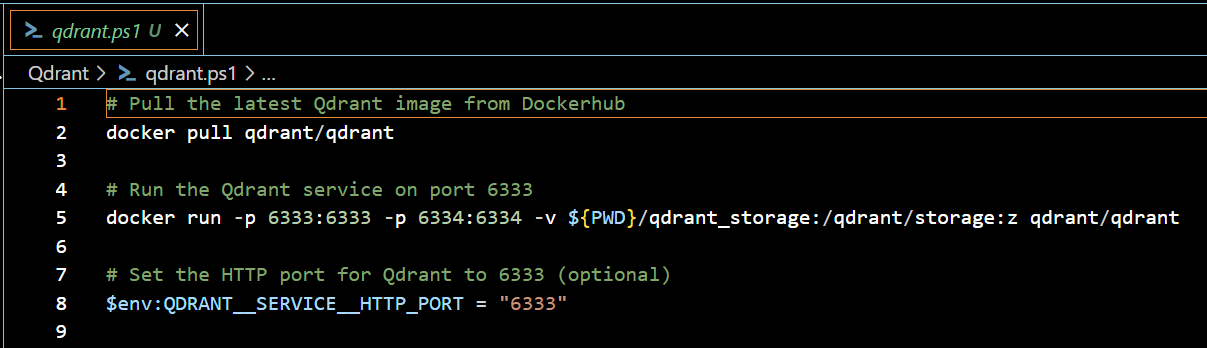

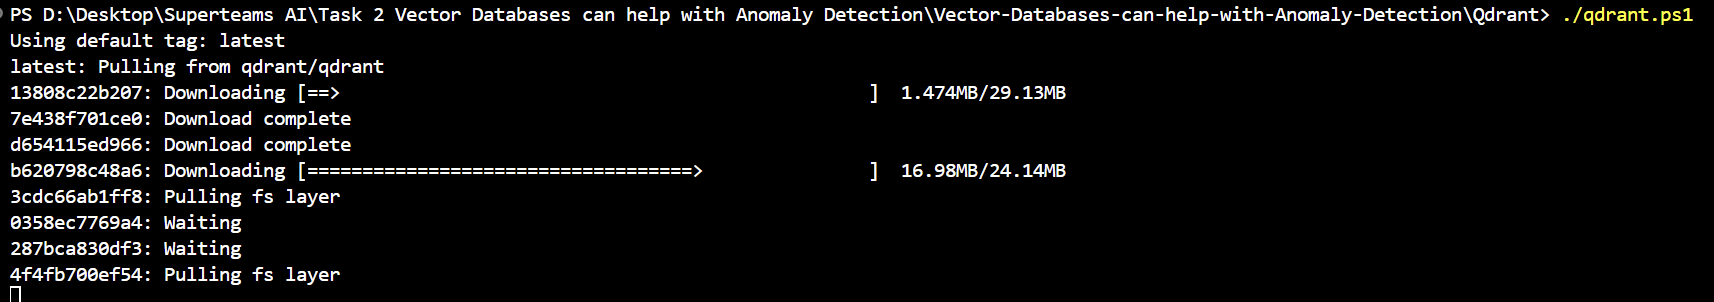

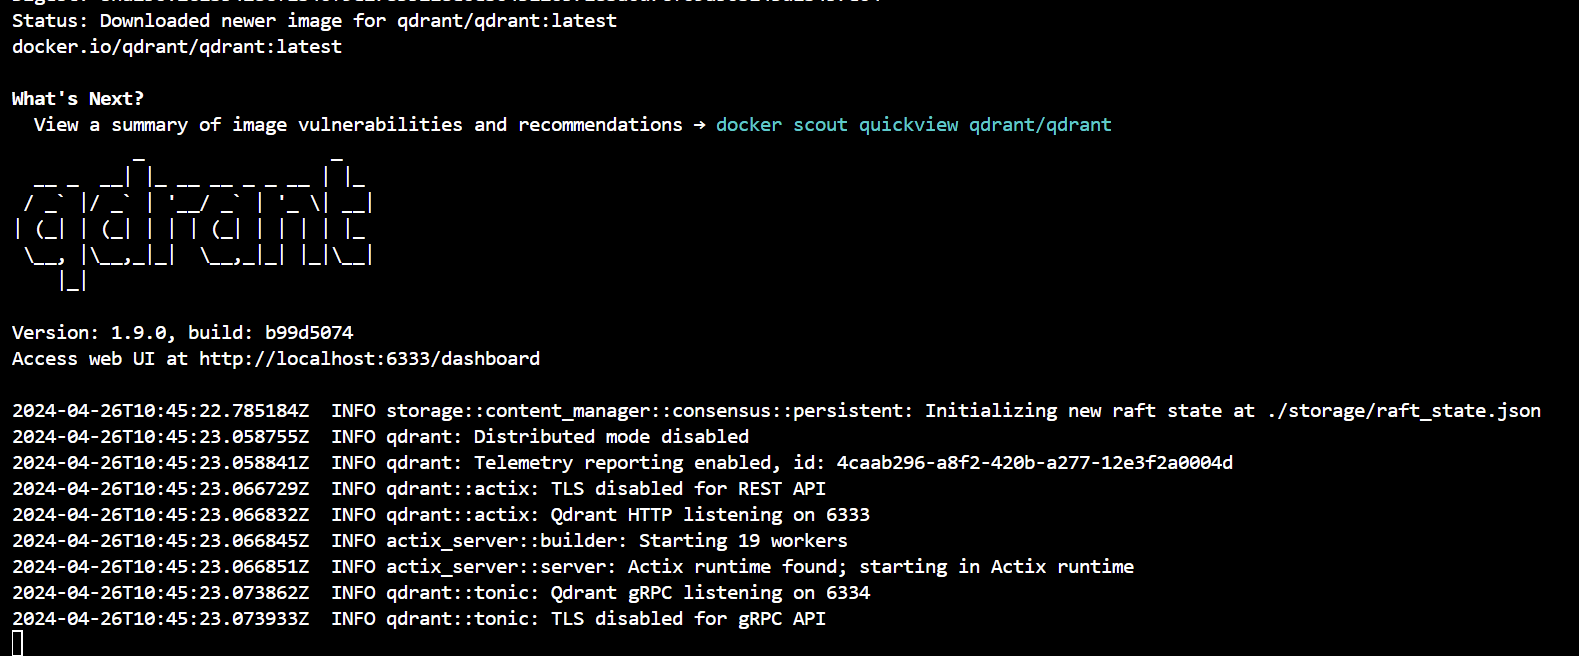

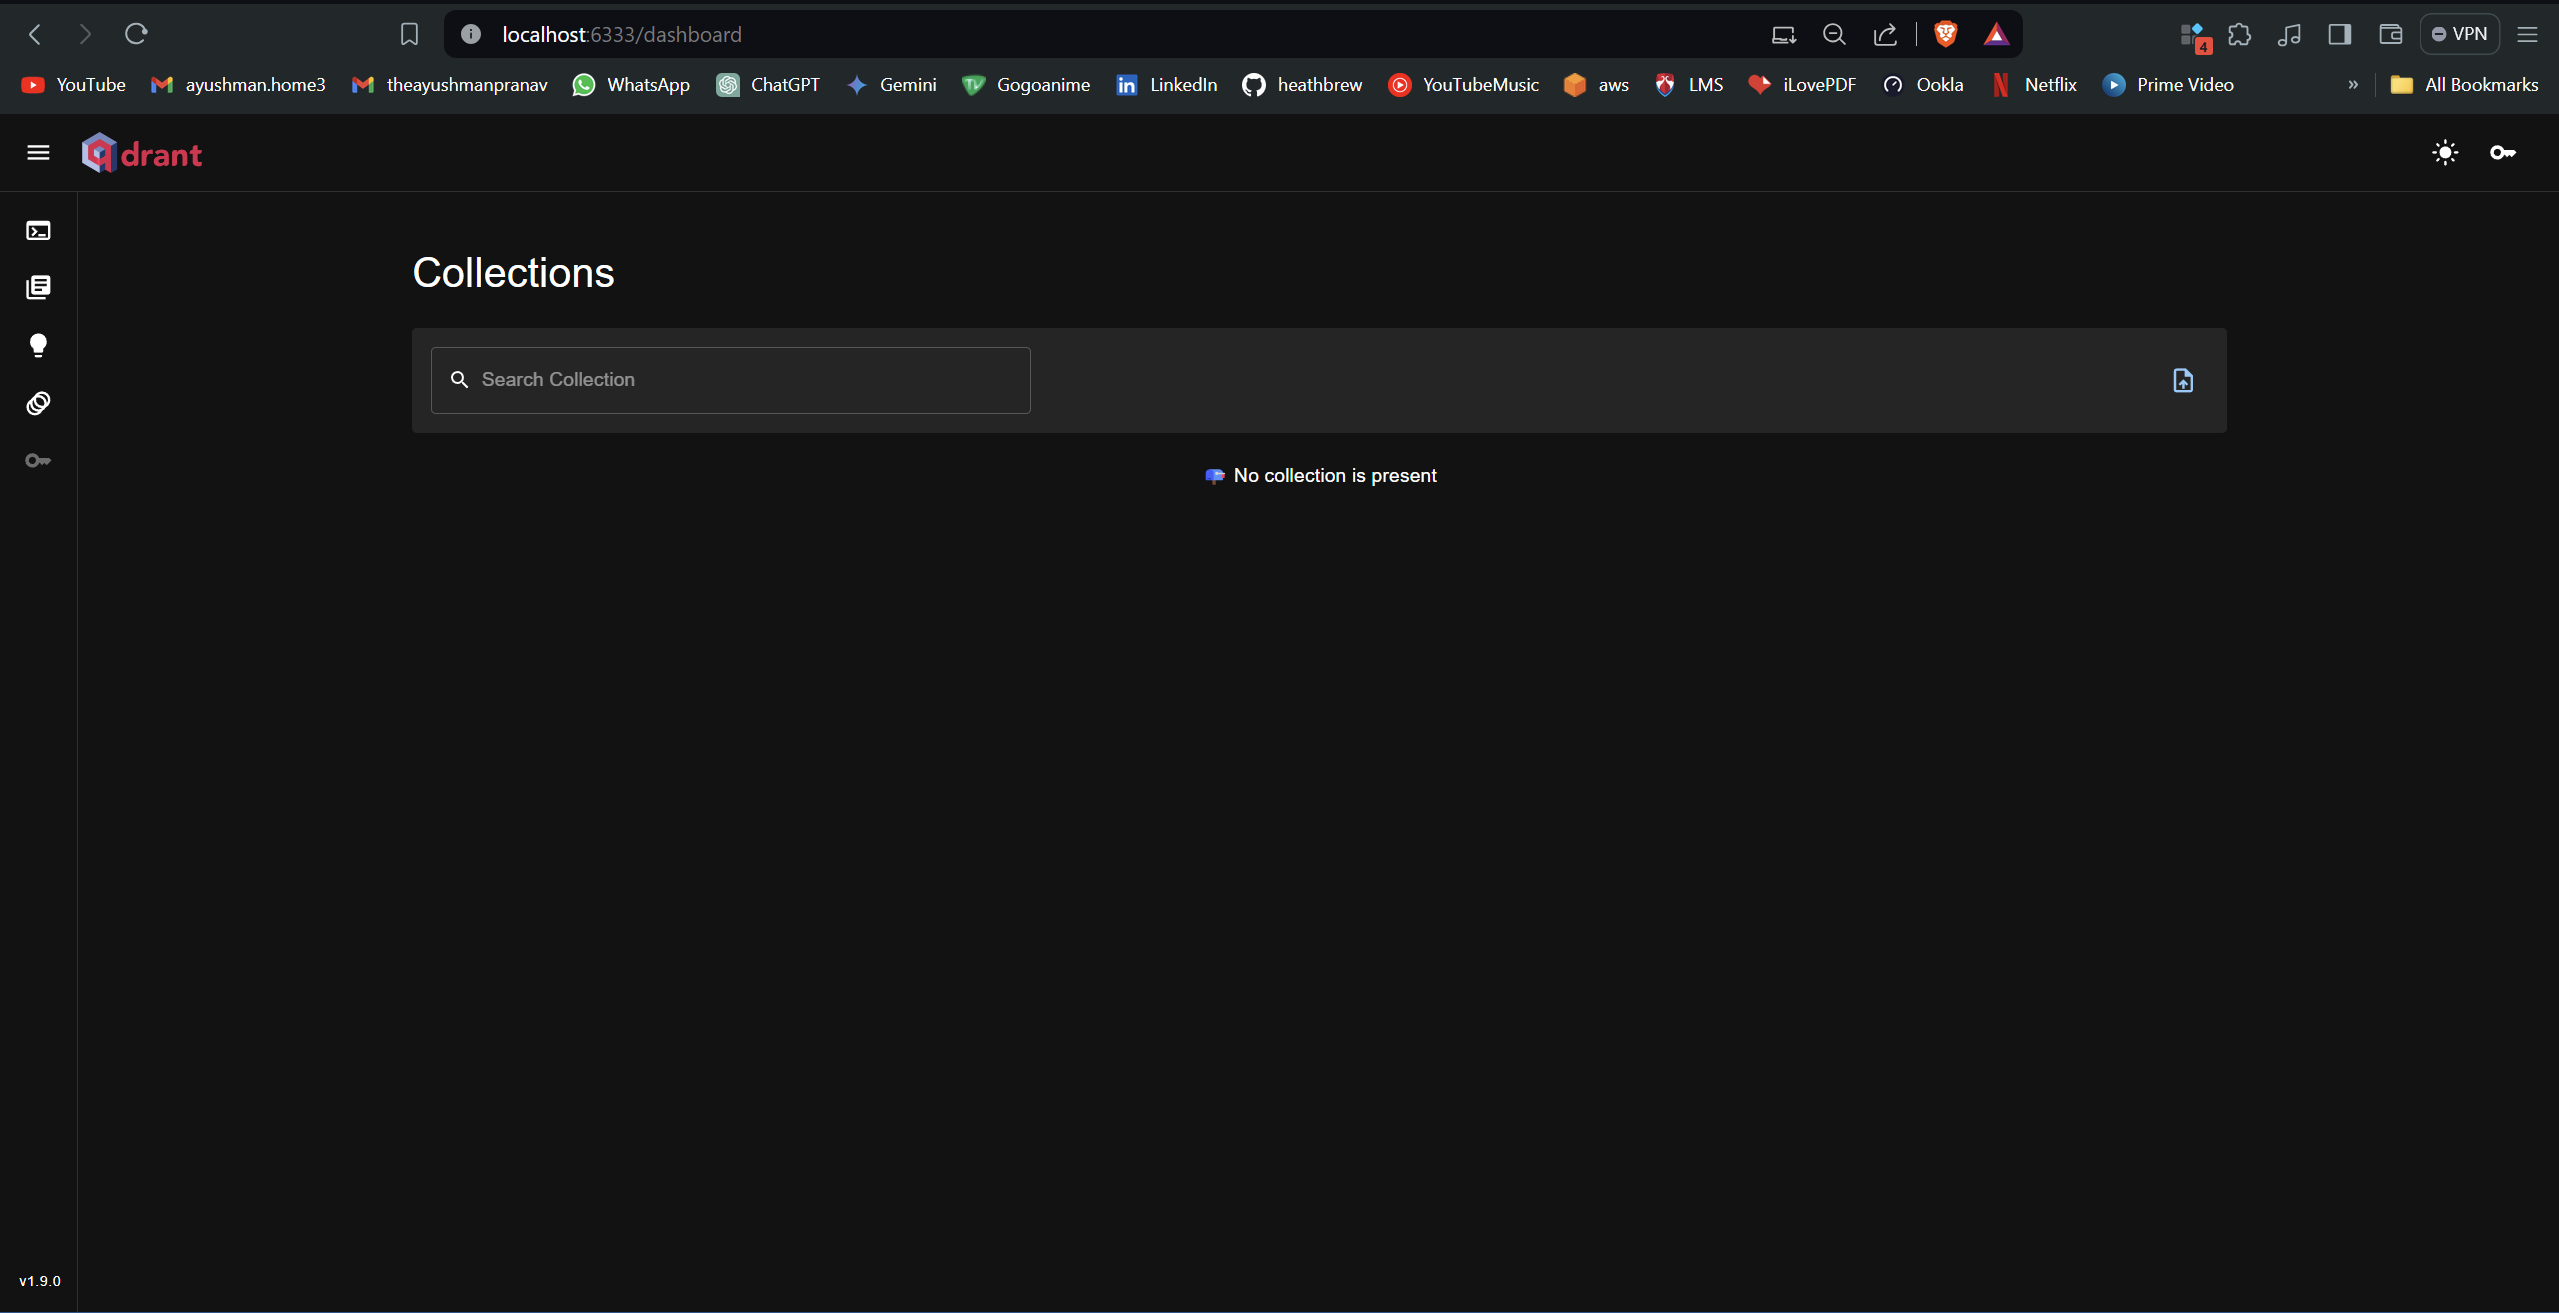

In [15]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize Qdrant client
qdrant_client = QdrantClient(host='localhost', port=6333)
collection_name = "Finance Outliers"

# Specify the vectors' configuration
vectors_config = VectorParams(
    size=model.config.hidden_size,  # The size of your embeddings
    distance=Distance.COSINE  # The distance metric for the vector space
)

# Create or recreate the collection with the specified configuration
qdrant_client.recreate_collection(
    collection_name=collection_name,
    vectors_config=vectors_config,
    # Optionally, you can specify other parameters for the collection
)



C:\Users\ayush\AppData\Local\Temp\ipykernel_28140\600000883.py:15: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(
2024-04-26 16:21:56 - INFO - HTTP Request: DELETE http://localhost:6333/collections/Finance%20Outliers "HTTP/1.1 200 OK"
2024-04-26 16:21:59 - INFO - HTTP Request: PUT http://localhost:6333/collections/Finance%20Outliers "HTTP/1.1 200 OK"


True

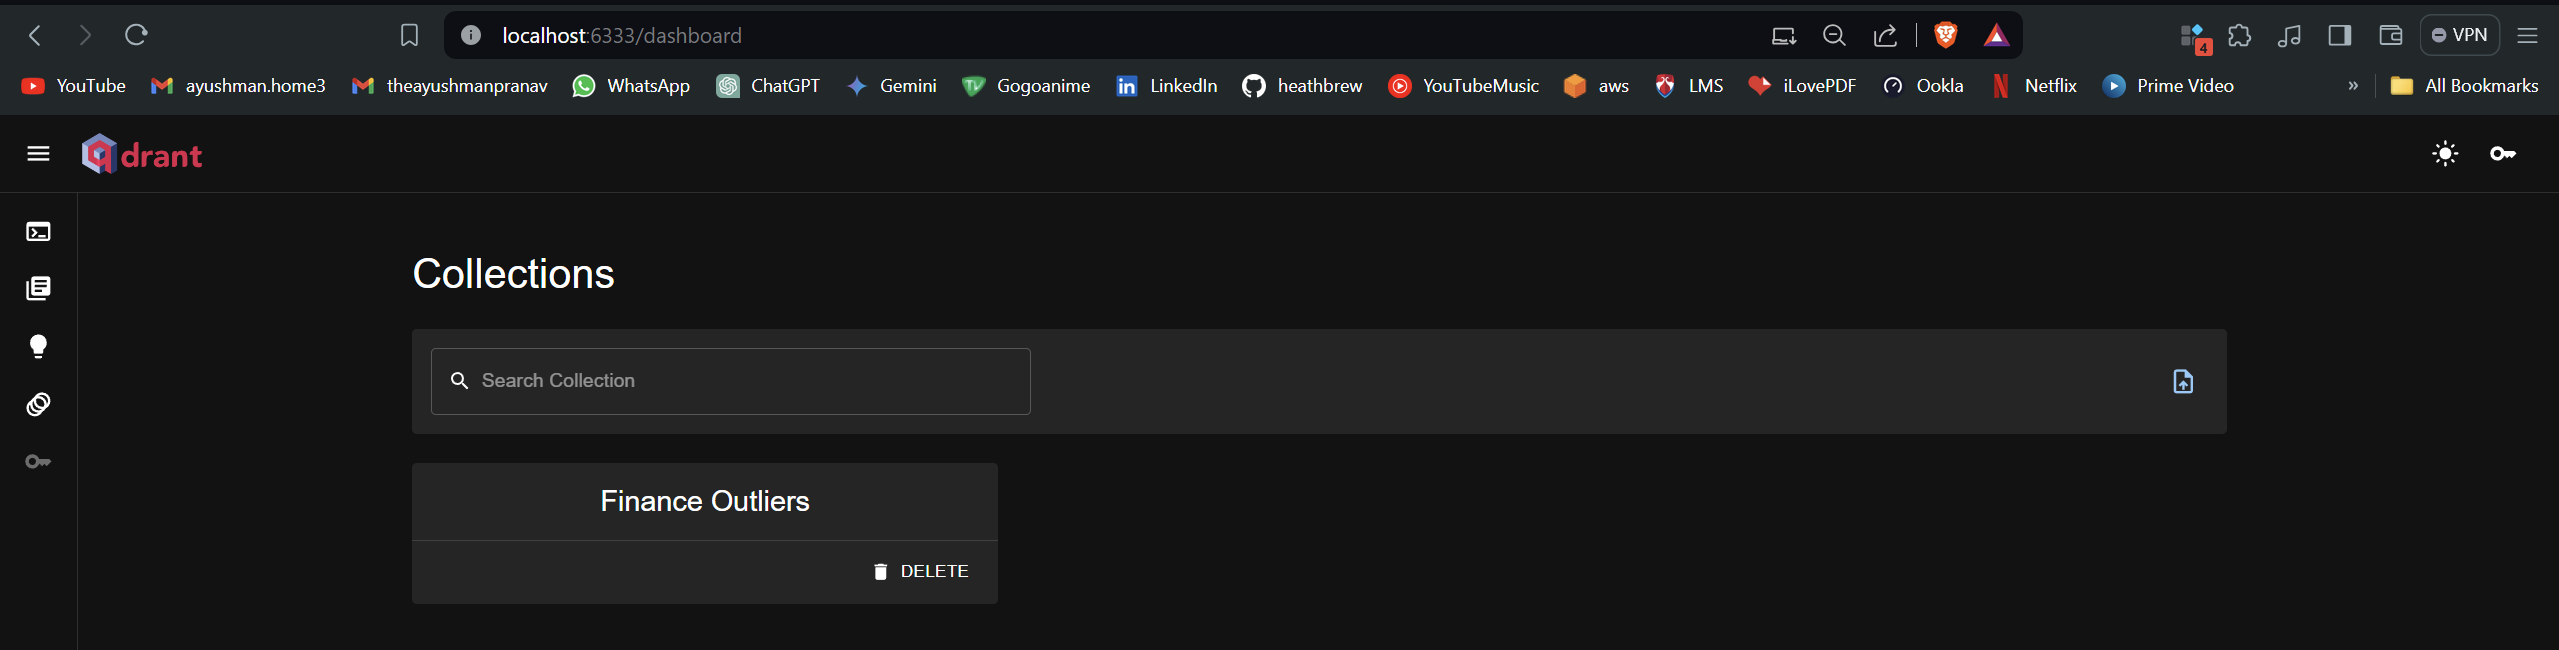

In [17]:
 # Insert data into Qdrant
for index, row in df.iterrows():
    qdrant_client.upsert(
        collection_name=collection_name,
        points=[{
            "id": index,  # Using the dataframe index as the ID
            "vector": row['encoded_news'],
            "payload": {
                # "instruction": row['instruction'], 
                # "input": row['input'],
                "output": row['news']
            }
        }]
    )


2024-04-26 16:23:41 - INFO - HTTP Request: PUT http://localhost:6333/collections/Finance%20Outliers/points?wait=true "HTTP/1.1 200 OK"
2024-04-26 16:23:41 - INFO - HTTP Request: PUT http://localhost:6333/collections/Finance%20Outliers/points?wait=true "HTTP/1.1 200 OK"
2024-04-26 16:23:41 - INFO - HTTP Request: PUT http://localhost:6333/collections/Finance%20Outliers/points?wait=true "HTTP/1.1 200 OK"
2024-04-26 16:23:41 - INFO - HTTP Request: PUT http://localhost:6333/collections/Finance%20Outliers/points?wait=true "HTTP/1.1 200 OK"
2024-04-26 16:23:41 - INFO - HTTP Request: PUT http://localhost:6333/collections/Finance%20Outliers/points?wait=true "HTTP/1.1 200 OK"
2024-04-26 16:23:41 - INFO - HTTP Request: PUT http://localhost:6333/collections/Finance%20Outliers/points?wait=true "HTTP/1.1 200 OK"
2024-04-26 16:23:41 - INFO - HTTP Request: PUT http://localhost:6333/collections/Finance%20Outliers/points?wait=true "HTTP/1.1 200 OK"
2024-04-26 16:23:41 - INFO - HTTP Request: PUT http://l

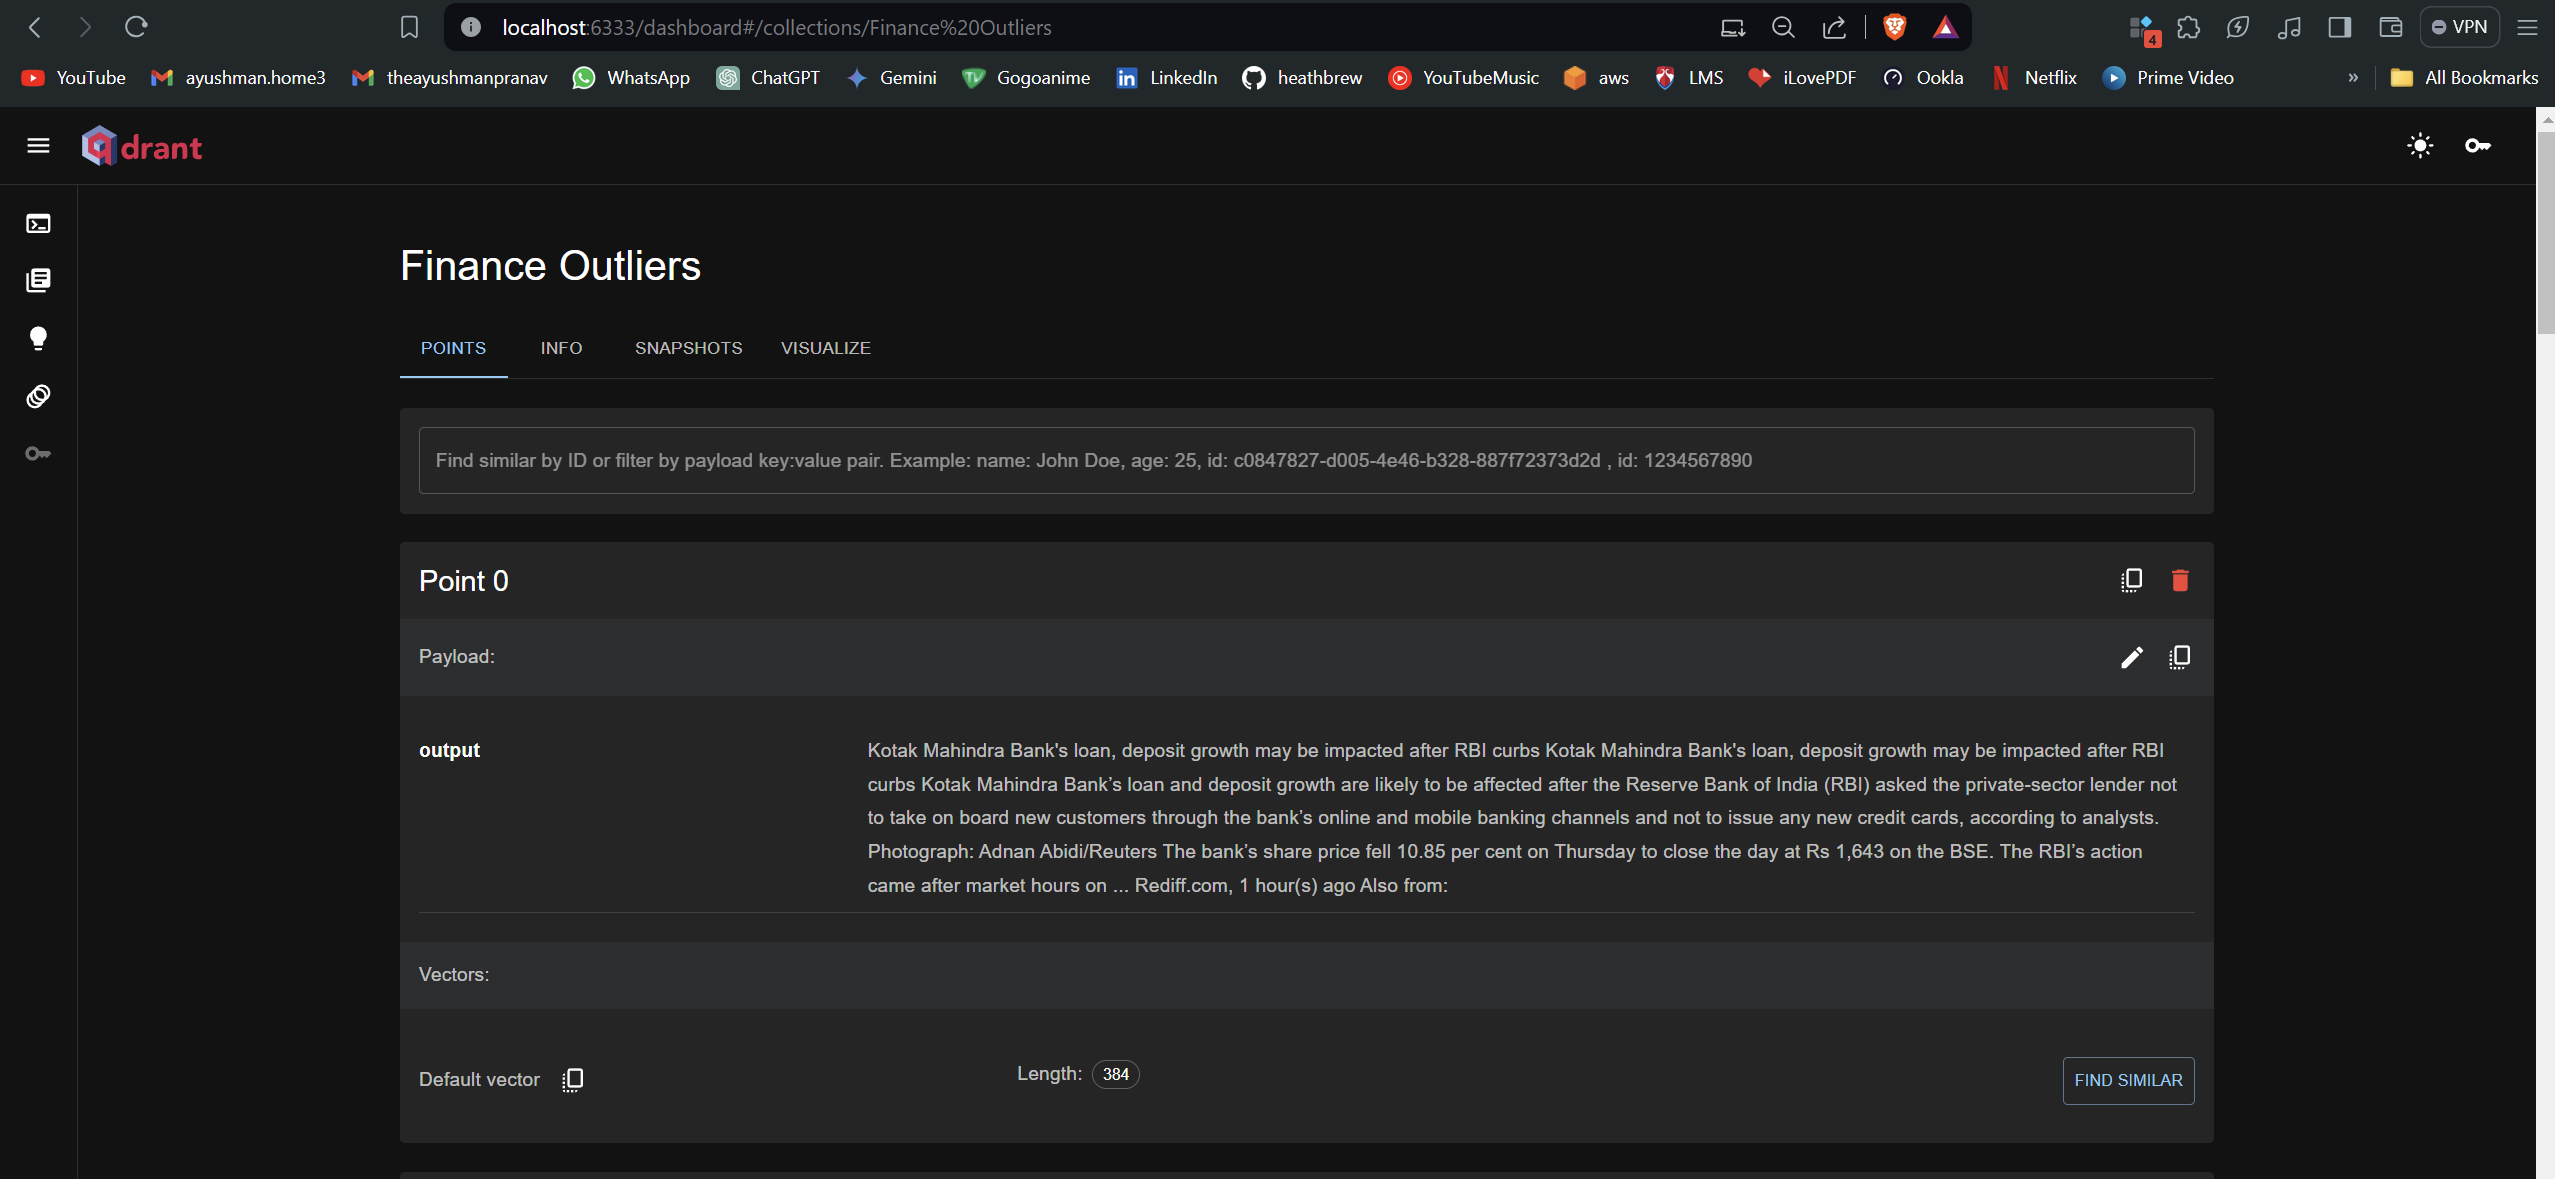

In [19]:
logging.info(f"qdrant '{collection_name}' collection created")

2024-04-26 16:24:49 - INFO - qdrant 'Finance Outliers' collection created


# Querying

In [22]:
from langchain.vectorstores import Qdrant

url = "http://localhost:6333"  # URL where the Qdrant service is running
collection_name =  "Finance Outliers"  # Name of the collection in Qdrant

# Initialize the Qdrant client with the specified URL
client = QdrantClient(
    url=url,
    prefer_grpc=False  # Indicates whether to use gRPC for communication
)

logging.info(f"QdrantClient initialized: {client}")  # Prints the client information
logging.info(f"#################################")  # Prints a separator line

# Create a Qdrant object with the specified client, embeddings, and collection name
# Initialize the Qdrant vector store from langchain
db = Qdrant(
    client=client,
    embeddings=df['encoded_news'].tolist(),  # Use the generated embeddings
    collection_name=collection_name
)

logging.info(f"Qdrant vector store initialized: {db}") # Prints the database object information

2024-04-26 16:27:55 - INFO - QdrantClient initialized: <qdrant_client.qdrant_client.QdrantClient object at 0x0000025DABB59D60>
2024-04-26 16:27:55 - INFO - #################################
D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\langchain_community\vectorstores\qdrant.py:150: UserWarning: `embeddings` should be an instance of `Embeddings`.Using `embeddings` as `embedding_function` which is deprecated
  warnings.warn(
2024-04-26 16:27:55 - INFO - Qdrant vector store initialized: <langchain_community.vectorstores.qdrant.Qdrant object at 0x0000025DAD359F70>


In [28]:
def similarity_search_with_score(query, k=2):
    query_embedding = generate_embedding(query)[0].tolist()
    search_results = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        limit=k,
        with_payload=True,
        with_vectors=False
    )
    return search_results

query = "Stock market crashes due to unexpected event"
search_results = similarity_search_with_score(query=query, k=5)

for result in search_results:
    doc_id = result.id
    score = result.score
    payload = result.payload  # The payload should contain your text or a reference to it.

    # Assuming the payload contains a field 'input' where the text is stored
    doc_content = payload.get('output', 'No content available')

    # Print the similarity score and document content
    logging.info({"score": score, "doc_id": doc_id, "content": doc_content})

2024-04-26 16:33:48 - INFO - HTTP Request: POST http://localhost:6333/collections/Finance%20Outliers/points/search "HTTP/1.1 200 OK"
2024-04-26 16:33:48 - INFO - {'score': 0.296198, 'doc_id': 0, 'content': "Kotak Mahindra Bank's loan, deposit growth may be impacted after RBI curbs Kotak Mahindra Bank's loan, deposit growth may be impacted after RBI curbs\n            Kotak Mahindra Bank’s loan and deposit growth are likely to be affected after the Reserve Bank of India (RBI) asked the private-sector lender not to take on board new customers through the bank’s online and mobile banking channels and not to issue any new credit cards, according to analysts.   Photograph: Adnan Abidi/Reuters The bank’s share price fell 10.85 per cent on Thursday to close the day at Rs 1,643 on the BSE. The RBI’s action came after market hours on ...\nRediff.com, 1 hour(s) ago\nAlso from:"}
2024-04-26 16:33:48 - INFO - {'score': 0.28810832, 'doc_id': 9, 'content': 'Sensex revisits 74K; Nifty climbs 168 poin

In [30]:
def similarity_search_with_score(query, k=2):
    query_embedding = generate_embedding(query)[0].tolist()
    search_results = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        limit=k,
        with_payload=True,
        with_vectors=False
    )

    # Extract the document content from the payload and include it in the results
    results_with_content = []
    for result in search_results:
        doc_id = result.id
        score = result.score
        payload = result.payload  # The payload should contain your text or a reference to it.
        
        # Extract the document content from the payload
        doc_content = payload.get('output', 'No content available')

        results_with_content.append((score, doc_content))

    # Sort the results based on the similarity score in descending order
    sorted_results = sorted(results_with_content, key=lambda x: x[0], reverse=True)

    # Concatenate the content of the top k results
    concatenated_content = ' '.join([content for _, content in sorted_results[:k]])

    return concatenated_content

query = "Stock market crashes due to unexpected event"
outlier_paragraph = similarity_search_with_score(query=query, k=5)

# Print the concatenated content
logging.info({"concatenated_content": outlier_paragraph})

2024-04-26 16:36:50 - INFO - HTTP Request: POST http://localhost:6333/collections/Finance%20Outliers/points/search "HTTP/1.1 200 OK"
2024-04-26 16:36:50 - INFO - {'concatenated_content': "Kotak Mahindra Bank's loan, deposit growth may be impacted after RBI curbs Kotak Mahindra Bank's loan, deposit growth may be impacted after RBI curbs\n            Kotak Mahindra Bank’s loan and deposit growth are likely to be affected after the Reserve Bank of India (RBI) asked the private-sector lender not to take on board new customers through the bank’s online and mobile banking channels and not to issue any new credit cards, according to analysts.   Photograph: Adnan Abidi/Reuters The bank’s share price fell 10.85 per cent on Thursday to close the day at Rs 1,643 on the BSE. The RBI’s action came after market hours on ...\nRediff.com, 1 hour(s) ago\nAlso from: Sensex revisits 74K; Nifty climbs 168 points Sensex revisits 74K; Nifty climbs 168 points\n            Rising for the fifth straight sessio

# RAG Summarization

In [40]:
query = "Stock market crashes due to unexpected event ?  Summarize this in one paragraph  "

In [41]:
from llama3backend import generate_text

RAG_answer = generate_text(str(query + outlier_paragraph)[:512])

Llama.generate: prefix-match hit


 debit cards or other payment instruments.
The RBI has taken this step as a precautionary measure to maintain financial stability in the country. The RBI has also asked Kotak Mahindra Bank to review its lending policies and ensure that they are in line with the RBI’s guidelines.
In conclusion, Kotak Mahindra Bank's loan and deposit growth may be impacted after the Reserve Bank of India (RBI) asked the private-sector lender not to take on board new customers through the bank’s online and mobile banking channels and not to issue any new credit cards, debit cards or other payment instruments. The RBI has taken this step as a precautionary measure to maintain financial stability in the country. The RBI has also asked Kotak Mahindra Bank to review its lending policies and ensure that they are in line with the RBI’s guidelines.
In conclusion, Kotak Mahindra Bank's loan and deposit growth may be impacted after the Reserve Bank of India (RBI) asked the private-sector lender not to take on boar


llama_print_timings:        load time =     971.24 ms
llama_print_timings:      sample time =     450.94 ms /   256 runs   (    1.76 ms per token,   567.70 tokens per second)
llama_print_timings: prompt eval time =     834.62 ms /    98 tokens (    8.52 ms per token,   117.42 tokens per second)
llama_print_timings:        eval time =    8760.02 ms /   255 runs   (   34.35 ms per token,    29.11 tokens per second)
llama_print_timings:       total time =   17771.24 ms /   353 tokens


In [42]:
# Print the concatenated content
logging.info({"RAG_answer": RAG_answer})

2024-04-26 16:45:20 - INFO - {'RAG_answer': " debit cards or other payment instruments.\nThe RBI has taken this step as a precautionary measure to maintain financial stability in the country. The RBI has also asked Kotak Mahindra Bank to review its lending policies and ensure that they are in line with the RBI’s guidelines.\nIn conclusion, Kotak Mahindra Bank's loan and deposit growth may be impacted after the Reserve Bank of India (RBI) asked the private-sector lender not to take on board new customers through the bank’s online and mobile banking channels and not to issue any new credit cards, debit cards or other payment instruments. The RBI has taken this step as a precautionary measure to maintain financial stability in the country. The RBI has also asked Kotak Mahindra Bank to review its lending policies and ensure that they are in line with the RBI’s guidelines.\nIn conclusion, Kotak Mahindra Bank's loan and deposit growth may be impacted after the Reserve Bank of India (RBI) ask